# How to use PyTorch

Pytorch has been developed at the Facebook AI Research group led by Yann LeCunn and the first alpha version released in September 2016. It provides deep integration with Python libraries like Numpy that can be used to extend its functionality, strong GPU acceleration, and automatic differentiation using its autograd system. It provides more granular control than Keras through a lower-level API and is mainly used as a deep learning research platform but can also replace NumPy while enabling GPU computation.

It employs eager execution, in contrast to the static computation graphs used by, e.g., Theano or TensorFlow. Rather than initially defining and compiling a network for fast but static execution, it relies on its autograd package for automatic differentiation of Tensor operations, i.e., it computes gradients ‘on the fly’ so that network structures can be partially modified more easily. This is called define-by-run, meaning that backpropagation is defined by how your code runs, which in turn implies that every single iteration can be different. The PyTorch documentation provides a detailed tutorial on this.

- [PyTorch Documentation](https://pytorch.org/docs)
- [PyTorch Tutorials](https://pytorch.org/tutorials)

The resulting flexibility combined with an intuitive Python-first interface and speed of execution have contributed to its rapid rise in popularity and led to the development of numerous supporting libraries that extend its functionality.

## Imports & Settings

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
%matplotlib inline

from pprint import pprint

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.datasets import make_circles

import torch
import torch.utils.data as utils
import torch.nn as nn
from torch.autograd import Variable
from livelossplot import PlotLosses

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
sns.set_style('white')

In [22]:
input_size = 2         # Input data dimensionality
hidden_size = 3        # The number of nodes at the hidden layer
num_classes = 2        # The number of output classes
num_epochs = 20         # The number of times entire dataset is trained
batch_size = 20        # The size of input data for one iteration
learning_rate = 0.01  # The speed of convergence

## Create Data

### Create Random Data

In [23]:
# dataset params
N = 50000
factor = 0.1
noise = 0.1

In [24]:
# generate data
X, y = make_circles(
    n_samples=N,
    shuffle=False,
    factor=factor,
    noise=noise)

### Create Torch Tensors

We begin by converting the NumPy or pandas input data to torch Tensors. Conversion from and to Numpy is very straightforward:

In [25]:
X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(y)

In [26]:
X_tensor.shape, y_tensor.shape

(torch.Size([50000, 2]), torch.Size([50000]))

### Create Torch Dataset

We can use these PyTorch Tensor to instantiate first a TensorDataset and, in a second step, a DataLoader that includes information about batch_size:

In [27]:
dataset = utils.TensorDataset(X_tensor,y_tensor)

### Define Torch DataLoader

In [28]:
dataloader = utils.DataLoader(dataset,
                              batch_size=batch_size,
                              shuffle=True)

## Build Network

### Architecture

PyTorch defines a NN architecture using the Net() class. The central element is the forward function. autograd automatically defines the corresponding backward function that computes the gradients. 

Any legal Tensor operation is fair game for the forward function, providing a log of design flexibility. In our simple case, we just link the Tensor through functional input-output relations after initializing their attributes.

In [29]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()                    # Inherited from the parent class nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.logistic = nn.LogSigmoid()                          
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        """Forward pass: stacking each layer together"""
        out = self.fc1(x)
        out = self.logistic(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

In [30]:
net = Net(input_size, hidden_size, num_classes)
net

Net(
  (fc1): Linear(in_features=2, out_features=3, bias=True)
  (logistic): LogSigmoid()
  (fc2): Linear(in_features=3, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [31]:
pprint(list(net.parameters()))

[Parameter containing:
tensor([[-0.0704,  0.5620],
        [-0.2632,  0.0945],
        [ 0.2829,  0.6046]], requires_grad=True),
 Parameter containing:
tensor([ 0.0554,  0.3589, -0.2276], requires_grad=True),
 Parameter containing:
tensor([[-0.4871, -0.4622, -0.5720],
        [-0.5635, -0.1131, -0.2391]], requires_grad=True),
 Parameter containing:
tensor([0.1253, 0.2512], requires_grad=True)]


In [32]:
list(net.parameters())[0]

Parameter containing:
tensor([[-0.0704,  0.5620],
        [-0.2632,  0.0945],
        [ 0.2829,  0.6046]], requires_grad=True)

### Enable GPU

To enable GPU processing, you can use net.cuda(). See Pytorch docs for placing Tensors on CPU and/or one or more GPU units.

In [33]:
# net.cuda()

### Define Loss Function

We also need to define a loss function and the optimizer, using some of the built-in options:

In [34]:
criterion = nn.CrossEntropyLoss()

### Select Optimizer

In [35]:
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

## Train Model

### Basic Training

Model training consists in an outer loop for each epoch, i.e., each pass over the training data, and an inner loop over the batches produced by the DataLoader. That executes the forward and backward passes of the learning algorithm. Some care needs to be taken to adjust data types to the requirements of the various objects and functions, e.g. labels need to be integers and the features should be of type floats:

In [36]:
for epoch in range(num_epochs):
    print(epoch)
    for i, (features, label) in enumerate(dataloader):
        
        features = Variable(features.float())         
        label = Variable(label.long())

        # Initialize the hidden weights
        optimizer.zero_grad()  
        
        # Forward pass: compute output given features
        outputs = net(features)
        
        # Compute the loss
        loss = criterion(outputs, label)
        # Backward pass: compute the gradients
        loss.backward()
        # Update the weights
        optimizer.step()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


### Plotting losses in real time

Below is an example that uses the `livelossplot` package to plot losses throughout the training process as provided by Keras out of the box.

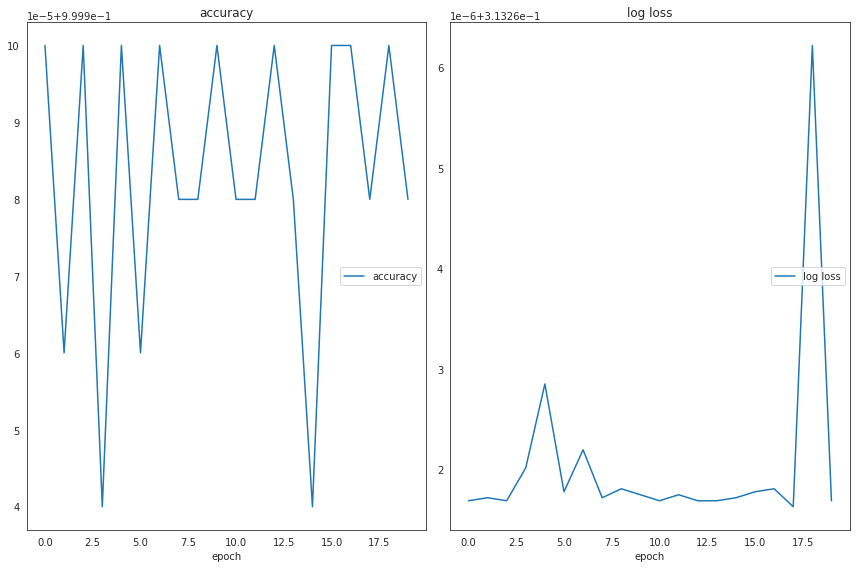

accuracy
	accuracy         	 (min:    1.000, max:    1.000, cur:    1.000)
log loss
	log loss         	 (min:    0.313, max:    0.313, cur:    0.313)


In [37]:
liveloss = PlotLosses()
for epoch in range(num_epochs):
    print(epoch)
    logs = {}
    running_loss = 0.0
    running_corrects = 0    
    for i, (features, label) in enumerate(dataloader):
        
        features = Variable(features.float())         
        label = Variable(label.long())

        # Intialize the hidden weight to all zeros
        optimizer.zero_grad()  
        
        # Forward pass: compute the output class given a image
        outputs = net(features)
        
        # Compute the loss: difference between the output class and the pre-given label
        loss = criterion(outputs, label)
        # Backward pass: compute the weight
        loss.backward()
        # Optimizer: update the weights of hidden nodes
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.detach() * features.size(0)
        running_corrects += torch.sum(preds == label.data)

        epoch_loss = running_loss / len(dataset)
        epoch_acc = running_corrects.float() / len(dataloader.dataset)        
        logs['log loss'] = loss.item()
        logs['accuracy'] = epoch_acc.item()

    liveloss.update(logs)
    liveloss.draw()        

## Predict

To obtain predictions from our trained model, we pass it feature data and convert the prediction to a Numpy array. We get softmax probabilities for each of the two classes:

In [38]:
test_value = Variable(torch.from_numpy(X)).float()
prediction = net(test_value).data.numpy()

In [39]:
prediction.shape

(50000, 2)

From here on, we can proceed as before to compute loss metrics or visualize the result that again reproduces a version of the decision boundary we found above.

### Score Prediction

In [40]:
accuracy_score(y_true=y, y_pred=np.argmax(prediction, axis=1))

1.0

## Visualize Decision Boundary

### Create Feature Space

In [41]:
n_vals = 200
x1 = np.linspace(-1.5, 1.5, num=n_vals)
x2 = np.linspace(-1.5, 1.5, num=n_vals)
xx, yy = np.meshgrid(x1, x2)  # create the grid

In [42]:
X_test = np.array([xx.ravel(), yy.ravel()]).T
X_test = torch.from_numpy(X_test)
X_test.shape

torch.Size([40000, 2])

### Predict Feature Space

In [43]:
zz = net(Variable(X_test).float()).data.numpy()
zz.shape

(40000, 2)

In [44]:
# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([sns.xkcd_rgb["pale red"],
                       sns.xkcd_rgb["denim blue"]])

### Plot Decision Boundary

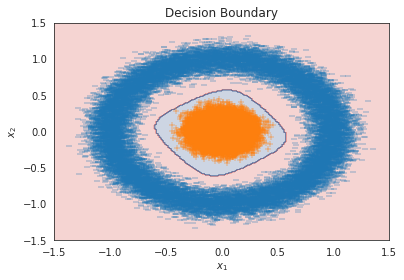

In [45]:
# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, np.argmax(zz, axis=1).reshape(n_vals, -1), cmap=cmap, alpha=.25)

# Plot both classes on the x1, x2 plane
data = pd.DataFrame(X, columns=['$x_1$', '$x_2$']).assign(Class=pd.Series(y).map({0:'negative', 1:'positive'}))
sns.scatterplot(x='$x_1$', y='$x_2$', hue='Class', data=data, style=y, markers=['_', '+'], legend=False)
plt.title('Decision Boundary');